# <u><span style="background-color: red;">__03_Entrenamiento_Evaluacion__</span></u>  

Objetivos:
- División train/test.
- Entrenamiento de 5 modelos supervisados (ARIMA, Prophet, Random Forest Regressor, Gradient Boosting, XGBoost).
- 1 modelo no supervisado (como clustering para segmentar patrones de venta).
- Hiperparametrización (GridSearchCV/RandomSearch).
- Evaluación con MAPE (principal) y MAE.

El orden del estudio sería el siguiente:  

### <u><span style="background-color: #00ffb792;">__A) Índice de modelos__</span></u>  

- [1 - Prophet](#1---prophet) → como baseline muy usado en negocio.  
- [2 - ARIMA](#2---arima) → otro baseline clásico de series temporales.  
- [3 - Random Forest Regressor](#3---random-forest-regressor) → primer modelo ML supervisado.  
- [4 - Gradient Boosting Regressor](#4---gradient-boosting-regressor) → más avanzado.  
- [5 - XGBoost Regressor](#5---xgboost-regressor) → boosting optimizado, potente.  
- [6 - CatBoostRegressor](#6---catboost-regressor) → modelo fuerte para compararlo con los anteriores. 
- [7 - Clustering (no supervisado)](#6---clustering-no-supervisado) → como análisis extra, no comparativo con lo anterior.  

### <u><span style="background-color: #00ffb792;">__B) Tabla comparativa__</span></u>  

### <u><span style="background-color: #00ffb792;">__C) Gráficas__</span></u>  

### <u><span style="background-color: #00ffb792;">__D) Guardar modelos__</span></u>  

--- 

#### **¿Por qué así?**

Primero damos contexto con los modelos clásicos de series temporales (Prophet, ARIMA). Luego avanzo a machine learning supervisado (Random Forest, Gradient Boosting, XGBoost). Finalmente termino con no supervisado (Clustering), que no predice sino que segmenta patrones.

--- 

#### **Sobre las métricas**  

Muy importante aclarar:

- MAPE, MAE, MSE, R² → sí, todos tienen sentido en regresión.
- ROC-AUC → no es válida en regresión. Solo sirve para clasificación binaria, ejm: predecir si habrá ventas altas/bajas, no la cantidad. Con lo cual no vamos a utilizarla para nuestro estudio.

Entonces:

- Para Prophet, ARIMA, Random Forest, Gradient Boosting, XGBoost usamos → MAPE, MAE, MSE, R².
- Para clustering (no supervisado) → usamos métricas diferentes: silhouette_score, inertia, etc.

In [1]:
# Importamos librerías generales

import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore")

### Generación de conjuntos Train/Test para cada granularidad

Antes de entrenar los modelos, es necesario preparar los conjuntos de entrenamiento y prueba
de forma consistente. En esta celda:

- Se definen rutas de proyecto y carpetas de salida.
- Se cargan los datasets procesados (`*_clean.csv`).
- Se generan características (features) específicas según la granularidad:
  - **Daily:** año, mes, día de la semana, lags (1 y 7), media móvil 7.
  - **Weekly:** año, semana, lags (1 y 2), media móvil 4.
  - **Monthly:** año, mes, lags (1 y 12), media móvil 3.
  - **Hourly:** año, mes, día, hora, día de la semana, lags (1 y 24), media móvil 24.
- Finalmente, se dividen los datos de cada granularidad en un **80% train** y **20% test**, 
guardando los resultados en las carpetas:
  - `data/train/` → ficheros `*_train.csv`
  - `data/test/` → ficheros `*_test.csv`

De este modo, los notebooks y scripts posteriores (entrenamiento, evaluación y clustering) 
tendrán siempre acceso a datasets coherentes y comparables.


In [2]:
# === Setup de rutas + guardado train/test para Daily/Weekly/Monthly/Hourly (con ../ fijo) ===
from pathlib import Path
import pandas as pd
import numpy as np
import sys

# Rutas fijas relativas al notebook (../ sube a la raíz del proyecto)
PROJECT_ROOT = Path("..").resolve()

DATA_DIR  = Path("../data")
PROC_DIR  = DATA_DIR / "processed"
TRAIN_DIR = DATA_DIR / "train"
TEST_DIR  = DATA_DIR / "test"

DOCS_DIR  = Path("../docs")
ARTI_DIR  = DOCS_DIR / "artifacts"
PLOTS_DIR = DOCS_DIR / "plots"

for d in (TRAIN_DIR, TEST_DIR, ARTI_DIR, PLOTS_DIR):
    d.mkdir(parents=True, exist_ok=True)

print("TRAIN_DIR :", TRAIN_DIR)
print("TEST_DIR  :", TEST_DIR)

# Importar utilidades desde src (para Daily reutilizamos tus funciones)
sys.path.insert(0, str(PROJECT_ROOT / "src"))
from utils import make_supervised_daily


# === Helpers para crear features por granularidad ===
def _ensure_datetime_sorted(df, date_col="datum"):
    d = df.copy()
    d[date_col] = pd.to_datetime(d[date_col], errors="coerce")
    d = d.dropna(subset=[date_col]).sort_values(date_col).reset_index(drop=True)
    return d

def _make_supervised_generic(df: pd.DataFrame, level: str):
    lvl = (level or "").strip().lower()
    if lvl == "daily":
        return make_supervised_daily(df)

    d = _ensure_datetime_sorted(df, "datum").copy()

    # Asegurar Total sales
    if "Total sales" not in d.columns:
        atc_cols = [c for c in ["M01AB","M01AE","N02BA","N02BE","N05B","N05C","R03","R06"] if c in d.columns]
        if atc_cols:
            d["Total sales"] = d[atc_cols].sum(axis=1, skipna=True)
        else:
            raise ValueError(f"{level}: falta 'Total sales' y no hay ATC.")

    d["Year"]    = d["datum"].dt.year
    d["Month"]   = d["datum"].dt.month
    d["Weekday"] = d["datum"].dt.dayofweek + 1

    if lvl == "weekly":
        d["Week"]   = d["datum"].dt.isocalendar().week.astype(int)
        d["lag_1"]  = d["Total sales"].shift(1)
        d["lag_2"]  = d["Total sales"].shift(2)
        d["roll4"]  = d["Total sales"].shift(1).rolling(4, min_periods=2).mean()
        feat_cols   = ["Year", "Week", "lag_1", "lag_2", "roll4"]

    elif lvl == "monthly":
        d["lag_1"]  = d["Total sales"].shift(1)
        d["lag_12"] = d["Total sales"].shift(12)
        d["roll3"]  = d["Total sales"].shift(1).rolling(3, min_periods=2).mean()
        feat_cols   = ["Year", "Month", "lag_1", "lag_12", "roll3"]

    elif lvl == "hourly":
        d["Day"]    = d["datum"].dt.day
        d["Hour"]   = d["datum"].dt.hour
        d["lag_1"]  = d["Total sales"].shift(1)
        d["lag_24"] = d["Total sales"].shift(24)
        d["roll24"] = d["Total sales"].shift(1).rolling(24, min_periods=6).mean()
        feat_cols   = ["Year", "Month", "Day", "Hour", "Weekday", "lag_1", "lag_24", "roll24"]

    else:
        raise ValueError(f"Granularidad no soportada: {level}")

    d = d.dropna(subset=feat_cols + ["Total sales"]).reset_index(drop=True)
    X = d[feat_cols].astype(float).copy()
    y = d["Total sales"].astype(float).values
    fechas = pd.to_datetime(d["datum"]).values
    return X, y, fechas, feat_cols


def _save_split(X, y, fechas, feat_cols, out_train: Path, out_test: Path, frac=0.2):
    n = len(X)
    cut = int(n*(1-frac))
    X_train, X_test = X[:cut], X[cut:]
    y_train, y_test = y[:cut], y[cut:]
    fechas_train, fechas_test = fechas[:cut], fechas[cut:]

    pd.DataFrame(X_train, columns=feat_cols) \
      .assign(y=y_train, fecha=fechas_train) \
      .to_csv(out_train, index=False)

    pd.DataFrame(X_test, columns=feat_cols) \
      .assign(y=y_test, fecha=fechas_test) \
      .to_csv(out_test, index=False)

    print(f"[OK] Guardado: {out_train}")
    print(f"[OK] Guardado: {out_test}")


# === Procesar cada granularidad ===
inputs = {
    "Daily":   PROC_DIR / "salesdaily_clean.csv",
    "Weekly":  PROC_DIR / "salesweekly_clean.csv",
    "Monthly": PROC_DIR / "salesmonthly_clean.csv",
    "Hourly":  PROC_DIR / "saleshourly_clean.csv",
}

for level, path in inputs.items():
    if not path.exists():
        print(f"[AVISO] No existe {path}. Omito {level}.")
        continue

    print(f"[INFO] Cargando {level}: {path}")
    df = pd.read_csv(path)

    if level == "Daily":
        X, y, fechas, feat_cols = make_supervised_daily(df)
    else:
        X, y, fechas, feat_cols = _make_supervised_generic(df, level)

    out_train = TRAIN_DIR / f"{level.lower()}_train.csv"
    out_test  = TEST_DIR  / f"{level.lower()}_test.csv"
    _save_split(X, y, fechas, feat_cols, out_train, out_test, frac=0.2)

print("[FIN] Splits guardados en data/train y data/test.")


TRAIN_DIR : ..\data\train
TEST_DIR  : ..\data\test
[INFO] Cargando Daily: ..\data\processed\salesdaily_clean.csv
[OK] Guardado: ..\data\train\daily_train.csv
[OK] Guardado: ..\data\test\daily_test.csv
[INFO] Cargando Weekly: ..\data\processed\salesweekly_clean.csv
[OK] Guardado: ..\data\train\weekly_train.csv
[OK] Guardado: ..\data\test\weekly_test.csv
[INFO] Cargando Monthly: ..\data\processed\salesmonthly_clean.csv
[OK] Guardado: ..\data\train\monthly_train.csv
[OK] Guardado: ..\data\test\monthly_test.csv
[INFO] Cargando Hourly: ..\data\processed\saleshourly_clean.csv
[OK] Guardado: ..\data\train\hourly_train.csv
[OK] Guardado: ..\data\test\hourly_test.csv
[FIN] Splits guardados en data/train y data/test.


Cargo los 4 datasets que tengo.

In [3]:
# Cargar los datasets
df_saleshourly_clean   = pd.read_csv("../data/processed/saleshourly_clean.csv")
df_salesdaily_clean    = pd.read_csv("../data/processed/salesdaily_clean.csv")
df_salesweekly_clean   = pd.read_csv("../data/processed/salesweekly_clean.csv")
df_salesmonthly_clean  = pd.read_csv("../data/processed/salesmonthly_clean.csv")

# cambio el nombre de clean a training para saber que estoy con los datasets para entrenamiento de los modelos
df_saleshourly_training  = df_saleshourly_clean
df_salesdaily_training   = df_salesdaily_clean
df_salesweekly_training  = df_salesweekly_clean
df_salesmonthly_training = df_salesmonthly_clean

Vamos a poner las utilidades comunes para no tener que repetirlas.

In [4]:
# Utilizades comunes

def mape(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

def evaluar(y_true, y_pred):
    return {
        "MAPE": mape(y_true, y_pred),
        "MAE": mean_absolute_error(y_true, y_pred),
        "MSE": mean_squared_error(y_true, y_pred),
        "R2": r2_score(y_true, y_pred),
    }

def temporal_split(df, date_col="datum", test_frac=0.2):
    df = df.sort_values(date_col).reset_index(drop=True)
    n = len(df)
    cut = int(n * (1 - test_frac))
    return df.iloc[:cut].copy(), df.iloc[cut:].copy()

def add_time_features_daily(df):
    """Features sencillas para Daily: calendario + lags + medias móviles cortas."""
    d = df.copy()
    d["datum"] = pd.to_datetime(d["datum"], errors="coerce")
    d = d.sort_values("datum").reset_index(drop=True)

    # calendario
    d["Year"] = d["datum"].dt.year
    d["Month"] = d["datum"].dt.month
    d["Weekday"] = d["datum"].dt.dayofweek + 1  # 1..7

    # lags y medias móviles (muy básicas)
    d["lag_1"] = d["Total sales"].shift(1)
    d["lag_7"] = d["Total sales"].shift(7)
    d["roll7"] = d["Total sales"].shift(1).rolling(7, min_periods=3).mean()
    d = d.dropna().reset_index(drop=True)

    feat_cols = ["Year","Month","Weekday","lag_1","lag_7","roll7"]

    # si existen columnas ATC, las añadimos porque ayudan
    atc = [c for c in ['M01AB','M01AE','N02BA','N02BE','N05B','N05C','R03','R06'] if c in d.columns]
    feat_cols = feat_cols + atc
    return d, feat_cols

In [5]:
# === Helpers extra mínimos ===

def make_supervised_daily(df):
    """Devuelve X, y, fechas ordenadas para Daily usando tus features."""
    d, feat_cols = add_time_features_daily(df)
    d = d.dropna(subset=["Total sales"])
    X = d[feat_cols].copy()
    y = d["Total sales"].astype(float).values
    fechas = d["datum"].values
    return X, y, fechas, feat_cols

def train_test_last_fraction(X, y, frac=0.2):
    """Split temporal simple: último 'frac' como test."""
    n = len(X); cut = int(n*(1-frac))
    return X[:cut], X[cut:], y[:cut], y[cut:]

# XGBoost (regresor) seguro:
try:
    from xgboost import XGBRegressor
except Exception as _:
    XGBRegressor = None

Recordemos el significado de las métricas:
- MAPE (principal en negocio): error porcentual medio. Más bajo = mejor.
- MAE: error absoluto medio en unidades de venta.
- MSE: penaliza más los errores grandes.
- R²: proporción de varianza explicada (cerca de 1 = muy bien).

### <u><span style="background-color: #00AAFF;">__1 - Prophet__</span></u> 
_--> No lo he hecho porque después de muchos intentos, sigue sin funcionar_

Modelo de Facebook/Meta muy usado en negocio porque combina tendencia + estacionalidad y es fácil de interpretar.  

No necesito features adicionales. Directamente se le pasa la fecha `ds` y valor `y`.  

Es bueno como primera referencia de predicción.

<u><span style="background-color:red;">__¡Atención!__</span></u>  

Como tengo Python 3.13 da problemas de compatibilidad en algunas librerías. Por ello, voy a proceder a crear un entorno virtual donde sí funcionen. Los comandos los vamos a ejecutar en la terminar de windows CMD o PowerShell.

Instalar python 3.11 si no lo tengo  
`winget install --id Python.Python.3.11 -e`  

Verifica las versiones instaladas con  
`py -0p`

Ir a la carpeta donde guardo los entornos  
`cd D:\_Proyectos_Data_Science\Windows_PowerShell\Entornos_Virtuales`  

Crear un nuevo entorno con Python 3.11  
`py -3.11 -m venv entorno_virtual_2`  

Esto me creará la carpeta  
`D:\_Proyectos_Data_Science\Windows_PowerShell\Entornos_Virtuales\entorno_virtual_2`   

Para activar el entorno en PowerSheel  
`D:\_Proyectos_Data_Science\Windows_PowerShell\Entornos_Virtuales\entorno_virtual_2\Scripts\Activate.ps1`  

Si sale un error, realiza este paso  
`Set-ExecutionPolicy -Scope Process -ExecutionPolicy Bypass`  
`D:\_Proyectos_Data_Science\Windows_PowerShell\Entornos_Virtuales\entorno_virtual_2\Scripts\Activate.ps1`  

Instalar dependencias para mi proyecto, por ejemplo  
`D:\_Proyectos_Data_Science\Windows_PowerShell\Entornos_Virtuales\entorno_virtual_2\Scripts\python.exe -m pip install --upgrade pip`  
`pip install pandas numpy matplotlib seaborn scikit-learn`  
`pip install statsmodels pmdarima`  
`pip install prophet`  
`pip install xgboost lightgbm catboost plotly streamlit`  

Registrar el entorno en jupyter  
`pip install ipykernel`  
`python -m ipykernel install --user --name=entorno_virtual_2 --display-name "Python (entorno_virtual_2)"`  

Después de todos estos pasos, según el kernel que tengamos y las características de nuestro ordenador, cada uno tendrá que adecuar e instalar lo que necesite para ejecutar el jupyter, como instalar Miniforge de conda.

In [6]:
# from prophet import Prophet
# from prophet.plot import plot_plotly
# from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score

### <u><span style="background-color: #00AAFF;">__2 - ARIMA__</span></u>   

--> *No exportaremos este modelo porque pesa mucho.*

Usamos SARIMAX con estacionalidad semanal (7), que suele ser razonable para ventas diarias.
Si quisiera probar variantes rápidas: cambio order=(p,d,q) y/o seasonal_order=(P,D,Q,7) y comparo MAPE.

In [7]:
# #########################################
# 2 - ARIMA
# #########################################

# === SARIMAX (ARIMA estacional) ===
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score

# Preparamos la serie univariante ordenada
daily = df_salesdaily_training.sort_values("datum").copy()
daily["datum"] = pd.to_datetime(daily["datum"], errors="coerce")
daily = daily.dropna(subset=["datum", "Total sales"])
y_all = pd.to_numeric(daily["Total sales"], errors="coerce").fillna(0.0).values

# Split temporal 80/20
cut = int(len(y_all) * 0.8)
y_tr, y_te = y_all[:cut], y_all[cut:]

# Ajuste SARIMAX: orden simple + estacionalidad semanal (P,D,Q, s=7)
model = SARIMAX(
    y_tr,
    order=(1, 1, 1),                 # p,d,q
    seasonal_order=(1, 0, 1, 7),     # P,D,Q,s  con s=7 (semanal)
    enforce_stationarity=False,
    enforce_invertibility=False
)
res = model.fit(disp=False)

# Forecast hasta el tamaño del test
yhat = res.forecast(steps=len(y_te))

# Métricas legibles
res_sarimax = evaluar(y_te, yhat)
print("=== SARIMAX (baseline) ===")
print(
    f"MAPE={res_sarimax['MAPE']:.3f} | "
    f"MAE={res_sarimax['MAE']:.3f} | "
    f"MSE={res_sarimax['MSE']:.3f} | "
    f"R2={res_sarimax['R2']:.3f}"
)

=== SARIMAX (baseline) ===
MAPE=33.571 | MAE=25.072 | MSE=1018.464 | R2=-0.938


Si MAPE de SARIMAX ≈ MAPE de tus modelos de boosting, tienes un baseline temporal fuerte. Si SARIMAX queda bastante peor, reforzaría que GBR/XGBoost capturan mejor la señal en tu dataset.  

**¿Cuándo ajustar órdenes (p,d,q / P,D,Q,s)?**
- Si hay patrón semanal fuerte → mantener s=7.
- Si la serie tiene tendencia clara → d=1.
- Si ves sobreajuste o problemas de convergencia → baja órdenes (p,q,P,Q).

### Justificación del uso de un orden fijo en SARIMAX

En este proyecto utilizamos **SARIMAX con orden fijo**:
- **ARIMA (p,d,q) = (1, 1, 1)**
- **Estacionalidad (P,D,Q,s) = (1, 0, 1, 7)**

> **Rol del modelo**: SARIMAX se ha empleado como **baseline clásico** de series temporales para comparar contra modelos de ML (GBR, XGB, CatBoost). El foco principal del proyecto está en los modelos supervisados modernos.

**Razonamiento del orden seleccionado**
- `d=1`: se observa tendencia en la serie diaria de ventas; una diferenciación ordinaria estabiliza la media.
- `p=1` y `q=1`: elección parsimoniosa guiada por la metodología Box–Jenkins (picos iniciales en ACF/PACF compatibles con componentes AR y MA de bajo orden).
- Estacionalidad semanal `s=7`: las ventas presentan **patrón semanal** (efecto día de la semana), por lo que se incluye SAR y SMA de bajo orden: `(P=1, D=0, Q=1)`.
- La combinación **(1,1,1)(1,0,1,7)** es un **punto de partida estándar** y suficientemente expresivo para capturar dependencias de corto plazo + componente semanal, sin entrar en una búsqueda extensiva.

**Por qué no se optimizó el orden en este código**
- **Costo computacional**: una búsqueda exhaustiva sobre (p,d,q)(P,D,Q) con validación temporal es costosa y añade poco valor si el objetivo es la comparativa con modelos de ML.
- **Evitar sobreajuste**: el ajuste fino de órdenes puede capturar ruido específico del periodo de entrenamiento y sesgar la comparación con modelos más robustos.
- **Consistencia metodológica**: mantenemos a SARIMAX como baseline parsimonioso, acorde a prácticas habituales cuando el foco no es la modelización ARIMA avanzada.

**Control metodológico**
- El modelo se entrenó sobre el tramo de entrenamiento y se evaluó **solo** en el tramo de test (20% final), evitando fuga temporal.
- Se comprobaron métricas en test (MAPE/MAE/MSE/R²) para contrastar su utilidad como referencia frente a los modelos ML.

**Líneas futuras (opcional)**
- **Selección automática** de órdenes con `auto_arima` (pmdarima), acotando rangos razonables y validando con **TimeSeriesSplit**.
- Comparar modelos por **AIC/BIC** y **métrica en holdout**; evaluar incluir **D=1** si hay estacionalidad multiplicativa fuerte o **exógenas (SARIMAX con X)** si se incorporan variables adicionales (festivos, campañas, mix ATC).
- Revisión de **estacionariedad** (e.g., prueba ADF) y diagnóstico de residuos (autocorrelación remanente).

> **Conclusión**: mantener **SARIMAX (1,1,1)(1,0,1,7)** como baseline proporciona un punto de referencia honesto y reproducible, suficiente para el objetivo de este trabajo, que es seleccionar el mejor modelo para despliegue entre las alternativas de ML.

### <u><span style="background-color: #00AAFF;">__3 - Random Forest Regressor__</span></u>  

In [8]:
# =========================================
# Preparación de datos supervisados (para modelos ML)
# =========================================

# Usamos el dataset diario como ejemplo principal
X, y, fechas, feat_cols = make_supervised_daily(df_salesdaily_training)

# Split temporal (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_last_fraction(X, y, frac=0.2)

print("Shapes ->", X_train.shape, X_test.shape)

Shapes -> (1679, 14) (420, 14)


- `TimeSeriesSplit` evita fuga temporal al validar (cada fold entrena en pasado y valida en futuro).

- `RandomizedSearchCV` da mejoras rápidas sin un grid enorme.

Mantiene un baseline (RF base) y un modelo optimizado (RF best) comparables con el resto.

In [9]:
# #########################################
# 3 - RANDOM FOREST REGRESSOR 
# #########################################

# === Random Forest Regressor ===
# (con tuning y TimeSeriesSplit)

from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score

# 1) Pipeline base: imputación -> RF
rf_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("model", RandomForestRegressor(
        n_estimators=300,
        max_depth=None,
        min_samples_split=2,
        random_state=42,
        n_jobs=-1
    ))
])

# 2) Entrenamiento base + evaluación
rf_pipe.fit(X_train, y_train)
y_pred_base = rf_pipe.predict(X_test)
res_rf_base = evaluar(y_test, y_pred_base)

print("=== RandomForest (Pipeline - base) ===")
print(f"MAPE={res_rf_base['MAPE']:.3f} | MAE={res_rf_base['MAE']:.3f} | MSE={res_rf_base['MSE']:.3f} | R2={res_rf_base['R2']:.3f}")

# 3) Tuning con validación temporal (TimeSeriesSplit)
tscv = TimeSeriesSplit(n_splits=3)

param_dist = {
    "model__n_estimators": [200, 300, 500, 800],
    "model__max_depth": [None, 6, 10, 14],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 2, 4],
    "model__max_features": ["sqrt", "log2", None]
}

rf_search = RandomizedSearchCV(
    estimator=rf_pipe,
    param_distributions=param_dist,
    n_iter=12,
    cv=tscv,                              # >>> validación temporal
    scoring="neg_mean_absolute_error",
    random_state=42,
    n_jobs=-1,
    refit=True
)

rf_search.fit(X_train, y_train)
rf_best = rf_search.best_estimator_

# 4) Evaluación del mejor RF
y_pred_best = rf_best.predict(X_test)
res_rf_best = evaluar(y_test, y_pred_best)

best_params_clean = {k.split("__", 1)[1]: v for k, v in rf_search.best_params_.items()}

print("\n=== RandomForest (Pipeline - best) ===")
print("Best params:", best_params_clean)
print(f"MAPE={res_rf_best['MAPE']:.3f} | MAE={res_rf_best['MAE']:.3f} | MSE={res_rf_best['MSE']:.3f} | R2={res_rf_best['R2']:.3f}")

# 5) Importancias de variables para interpretación
try:
    rf_model_best = rf_best.named_steps["model"]
    importancias = pd.Series(rf_model_best.feature_importances_, index=X_train.columns).sort_values(ascending=False)
    print("\nTop 10 features (RF - best):")
    for name, val in importancias.head(10).items():
        print(f"- {name:<18}: {val:.4f}")
except Exception:
    pass

=== RandomForest (Pipeline - base) ===
MAPE=5.192 | MAE=3.349 | MSE=27.208 | R2=0.948

=== RandomForest (Pipeline - best) ===
Best params: {'n_estimators': 800, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': None}
MAPE=5.093 | MAE=3.284 | MSE=26.306 | R2=0.950

Top 10 features (RF - best):
- N02BE             : 0.7756
- N05B              : 0.0744
- R03               : 0.0700
- M01AB             : 0.0207
- N02BA             : 0.0171
- M01AE             : 0.0129
- R06               : 0.0077
- lag_1             : 0.0045
- roll7             : 0.0045
- lag_7             : 0.0044


Recordamos que cuando hicimos la función `add_time_features_daily(df)` añadimos variables temporales derivadas de la serie de ventas `Total sales`:  

`**lag_1**`  
- Es el valor de ventas del día anterior.
- Ejemplo: si hoy es 10 de enero, lag_1 = ventas del 9 de enero.
- Sirve para que el modelo aprenda la dependencia inmediata (autocorrelación a corto plazo).

`**lag_7**`
- Es el valor de ventas de hace 7 días.
- Ejemplo: si hoy es lunes 10 de enero, lag_7 = ventas del lunes 3 de enero.
- Se usa porque muchas series de ventas tienen un patrón semanal.

`**roll7**`
- Es la media móvil de los últimos 7 días, pero desplazada 1 día (para no “ver el futuro”).
- Fórmula: promedio de Total sales de los 7 días anteriores a la fecha actual.
- Ejemplo: para 10 de enero → promedio entre el 3 y 9 de enero.
- Ayuda al modelo a captar la tendencia suave de la serie en lugar de solo valores puntuales.

**¿Qué significa cada valor del top 10?**  

- Cada feature (columna usada como predictor) recibe un valor entre 0 y 1.  
- Cuanto mayor es el valor, más contribuye esa variable a las decisiones de los árboles dentro del Random Forest.
- La suma de todas las importancias da 1.0 (100%).

En este caso:

- **N02BE (0.7761 → 77,6%)**  
Este grupo ATC (medicamentos analgésicos como el paracetamol) explica por sí solo casi el 78% del poder predictivo del modelo. Es el driver principal de tus ventas.

- **N05B (7,4%) y R03 (6,9%)**  
Otros dos grupos ATC que también aportan bastante peso.

- **M01AB, N02BA, M01AE, R06**  
Cada uno aporta en torno al 1–2%.

- **roll7 (media móvil de 7 días), lag_1 y lag_7 (valores pasados)**  
Aportan muy poco (<0.5% cada uno). Esto indica que, al menos en este dataset, las características de calendario/lags no tienen tanta fuerza predictiva como los grupos ATC.  

**Conclusión** 
- El modelo se apoya fuertemente en las ventas del grupo `N02BE` para explicar las ventas diarias totales.
- La predicción depende casi exclusivamente de cómo se comporta N02BE. El resto de variables ayudan, pero mucho menos

### <u><span style="background-color: #00AAFF;">__4 - Gradient Boosting Regressor__</span></u>   

Es un ensamble de árboles pequeños (débiles) que se entrenan secuencialmente, corrigiendo el error del anterior. Suele capturar relaciones no lineales y funciona muy bien en tabulares.

In [10]:
# #########################################
# 4 - GRADIENT BOOSTING REGRESSOR
# #########################################

# === GradientBoosting Regressor ===

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score

# --- Modelo base (Pipeline: imputación -> GBR) ---
gbr_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("model", GradientBoostingRegressor(
        n_estimators=400,
        learning_rate=0.05,
        max_depth=3,
        random_state=42
    ))
])

gbr_pipe.fit(X_train, y_train)
y_pred_base = gbr_pipe.predict(X_test)
res_base = evaluar(y_test, y_pred_base)

print("=== GradientBoosting (Pipeline - base) ===")
print(
    f"MAPE={res_base['MAPE']:.3f} | "
    f"MAE={res_base['MAE']:.3f} | "
    f"MSE={res_base['MSE']:.3f} | "
    f"R2={res_base['R2']:.3f}"
)

# --- Búsqueda de hiperparámetros (GridSearchCV sobre el Pipeline) ---
param_grid = {
    "model__n_estimators": [200, 400, 600],
    "model__learning_rate": [0.03, 0.05, 0.1],
    "model__max_depth": [2, 3, 4],
}

gbr_search = GridSearchCV(
    estimator=gbr_pipe,
    param_grid=param_grid,
    cv=3,
    n_jobs=-1,
    scoring="neg_mean_absolute_error",
    refit=True
)

gbr_search.fit(X_train, y_train)
gbr_best = gbr_search.best_estimator_

y_pred_best = gbr_best.predict(X_test)
res_best = evaluar(y_test, y_pred_best)

# Limpiar claves ('model__' -> '')
best_params_clean = {k.split("__", 1)[1]: v for k, v in gbr_search.best_params_.items()}

print("\n=== GradientBoosting (Pipeline - best) ===")
print("Best params:", best_params_clean)
print(
    f"MAPE={res_best['MAPE']:.3f} | "
    f"MAE={res_best['MAE']:.3f} | "
    f"MSE={res_best['MSE']:.3f} | "
    f"R2={res_best['R2']:.3f}"
)

# Importancias de variables en GBR
if hasattr(gbr_best.named_steps["model"], "feature_importances_"):
    importances_gb = gbr_best.named_steps["model"].feature_importances_
    features = X_train.columns
    feat_importances = pd.DataFrame({"Feature": features, "Importance": importances_gb})
    feat_importances = feat_importances.sort_values("Importance", ascending=False)

    print("\n=== Importancia de variables - GradientBoostingRegressor ===")
    print(feat_importances.head(10))

=== GradientBoosting (Pipeline - base) ===
MAPE=2.578 | MAE=1.650 | MSE=6.523 | R2=0.988

=== GradientBoosting (Pipeline - best) ===
Best params: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 600}
MAPE=1.996 | MAE=1.277 | MSE=3.984 | R2=0.992

=== Importancia de variables - GradientBoostingRegressor ===
   Feature  Importance
9    N02BE    0.724410
12     R03    0.095620
10    N05B    0.085319
8    N02BA    0.033701
6    M01AB    0.029505
7    M01AE    0.017778
13     R06    0.010497
11    N05C    0.002764
5    roll7    0.000232
3    lag_1    0.000068


El modelo base, GradientBoosting, tiene los siguientes valores:  

- MAPE ~2.58%: error porcentual medio muy bajo (excelente para ventas).
- MAE 1.65: error medio absoluto en unidades de ventas.
- R² 0.988: explica el 98.8% de la variabilidad.

El mejor modelo, GradientBoosting (best), da los siguientes resultados y el grid elegido es:
- Mejora clara respecto al base (MAPE baja de 2.58% → 1.996%)
- learning_rate=0.1 (más alto): avanza más en cada iteración
- max_depth=2 (más simple): árboles aún más pequeños para no sobreajustar
- n_estimators=600 (más rondas): compensa la menor profundidad.

En definitiva, con más iteraciones con árboles muy simples y un paso algo mayor ha dado un sesgo/varianza equilibrado mejor.

**Conclusiones**

GBR tuned es, ahora mismo, el mejor modelo (MAPE ≈ 2%).

Estable y explicable: aunque no tan interpretable como un ARIMA, puedo extraer importancias de variables (best_gbr.feature_importances_) para explicar drivers de ventas (p. ej., categorías ATC, lags, estacionalidad).

Accionable: ese nivel de error permite planificar stock y recursos con más confianza (±2% de margen medio).

### <u><span style="background-color: #00AAFF;">__5 - XGBoost Regressor__</span></u>   

Es un algoritmo de gradient boosting muy optimizado que entrena muchos árboles pequeños en secuencia. Cada árbol corrige los errores del anterior. Suele rendir muy bien en datos tabulares y soporta regularización para evitar sobreajuste.



In [11]:
# #########################################
# 5 - XGBOOST REGRESSOR
# #########################################

# Imports mínimos del apartado
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score

try:
    from xgboost import XGBRegressor
except Exception:
    XGBRegressor = None

if XGBRegressor is None:
    print("XGBoost no está instalado en este entorno. Instala con: pip install xgboost")
else:
    # --- Modelo base (Pipeline: imputación -> XGB) ---
    xgb_pipe = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("model", XGBRegressor(
            n_estimators=600,
            max_depth=4,
            learning_rate=0.05,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_lambda=1.0,
            random_state=42,
            n_jobs=-1
        ))
    ])

    xgb_pipe.fit(X_train, y_train)
    y_pred_base = xgb_pipe.predict(X_test)
    res_base = evaluar(y_test, y_pred_base)

    print("=== XGBoost (Pipeline - base) ===")
    print(
        f"MAPE={res_base['MAPE']:.3f} | "
        f"MAE={res_base['MAE']:.3f} | "
        f"MSE={res_base['MSE']:.3f} | "
        f"R2={res_base['R2']:.3f}"
    )

    # --- Búsqueda aleatoria con validación temporal ---
    tscv = TimeSeriesSplit(n_splits=3)
    param_distributions = {
        "model__n_estimators": [400, 600, 800],
        "model__max_depth": [3, 4, 5],
        "model__learning_rate": [0.03, 0.05, 0.1],
        "model__subsample": [0.7, 0.8, 1.0],
        "model__colsample_bytree": [0.7, 0.8, 1.0],
        "model__reg_lambda": [0.5, 1.0, 2.0],
    }

    xgb_search = RandomizedSearchCV(
        estimator=xgb_pipe,
        param_distributions=param_distributions,
        n_iter=12,
        cv=tscv,                         # validación temporal
        scoring="neg_mean_absolute_error",
        random_state=42,
        n_jobs=-1,
        refit=True
    )

    xgb_search.fit(X_train, y_train)
    xgb_best = xgb_search.best_estimator_

    y_pred_best = xgb_best.predict(X_test)
    res_best = evaluar(y_test, y_pred_best)

    best_params_clean = {k.split("__", 1)[1]: v for k, v in xgb_search.best_params_.items()}

    print("\n=== XGBoost (Pipeline - best) ===")
    print("Best params:", best_params_clean)
    print(
        f"MAPE={res_best['MAPE']:.3f} | "
        f"MAE={res_best['MAE']:.3f} | "
        f"MSE={res_best['MSE']:.3f} | "
        f"R2={res_best['R2']:.3f}"
    )

    # Importancias de variables en XGB
if hasattr(xgb_best.named_steps["model"], "feature_importances_"):
    importances_xgb = xgb_best.named_steps["model"].feature_importances_
    features = X_train.columns
    feat_importances_xgb = pd.DataFrame({"Feature": features, "Importance": importances_xgb})
    feat_importances_xgb = feat_importances_xgb.sort_values("Importance", ascending=False)

    print("\n=== Importancia de variables - XGBoost ===")
    print(feat_importances_xgb.head(10))

=== XGBoost (Pipeline - base) ===
MAPE=2.374 | MAE=1.531 | MSE=7.634 | R2=0.986

=== XGBoost (Pipeline - best) ===
Best params: {'subsample': 0.7, 'reg_lambda': 0.5, 'n_estimators': 800, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.8}
MAPE=1.964 | MAE=1.235 | MSE=3.716 | R2=0.993

=== Importancia de variables - XGBoost ===
   Feature  Importance
9    N02BE    0.475158
12     R03    0.129211
10    N05B    0.107676
5    roll7    0.065473
6    M01AB    0.058682
8    N02BA    0.058349
7    M01AE    0.051331
13     R06    0.027689
11    N05C    0.013000
3    lag_1    0.009382


**Conclusiones**

Rendimiento
- Si XGBoost da un MAPE <= al de GradientBoosting (que ya dio ~2%), es muy competitivo.
- Si no lo mejora, GBR “tuned” puede ser el ganador, es habitual en tabular que ambos queden muy parejos.

Sesgo vs. varianza
- Si R² muy alto y MSE bajo, el modelo generaliza bien.
- Si entrenando sube mucho y en test cae, sube regularización: baja max_depth, sube reg_lambda, baja colsample_bytree/subsample, o baja learning_rate y sube n_estimators.

Acción de negocio
- Una vez elegido el modelo (GBR/XGB), se usará para predicciones operativas (stock, personal, promos) y analizar drivers con importancias.

### <u><span style="background-color: #00AAFF;">__6 - CatBoost Regressor__</span></u>  

In [12]:
# #########################################
# 6 - CATBOOST REGRESSOR
# #########################################

from catboost import CatBoostRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score

# --- Modelo base (Pipeline: imputación -> CatBoost) ---
cat_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("model", CatBoostRegressor(
        loss_function="RMSE",
        random_seed=42,
        logging_level="Silent"
    ))
])

cat_pipe.fit(X_train, y_train)
y_pred_base = cat_pipe.predict(X_test)
res_base = evaluar(y_test, y_pred_base)

print("=== CatBoost (Pipeline - base) ===")
print(
    f"MAPE={res_base['MAPE']:.3f} | "
    f"MAE={res_base['MAE']:.3f} | "
    f"MSE={res_base['MSE']:.3f} | "
    f"R2={res_base['R2']:.3f}"
)

# --- Búsqueda aleatoria de hiperparámetros con validación temporal ---
tscv = TimeSeriesSplit(n_splits=3)

param_distributions = {
    "model__n_estimators": [400, 600, 800],
    "model__depth": [4, 6, 8],
    "model__learning_rate": [0.03, 0.05, 0.1],
    "model__subsample": [0.7, 0.8, 1.0],
    "model__l2_leaf_reg": [1.0, 3.0, 5.0, 7.0],
}

cat_search = RandomizedSearchCV(
    estimator=cat_pipe,
    param_distributions=param_distributions,
    n_iter=12,
    cv=tscv,
    n_jobs=-1,
    random_state=42,
    scoring="neg_mean_absolute_error",
    refit=True
)

cat_search.fit(X_train, y_train)

cat_best = cat_search.best_estimator_
y_pred_best = cat_best.predict(X_test)
res_best = evaluar(y_test, y_pred_best)

best_params_clean = {k.split("__", 1)[1]: v for k, v in cat_search.best_params_.items()}

print("\n=== CatBoost (Pipeline - best) ===")
print("Best params:", best_params_clean)
print(
    f"MAPE={res_best['MAPE']:.3f} | "
    f"MAE={res_best['MAE']:.3f} | "
    f"MSE={res_best['MSE']:.3f} | "
    f"R2={res_best['R2']:.3f}"
)

# === Importancia de variables en CatBoost ===
# Funciona tanto si tienes 'cat_best' (tras tuning) como sólo 'cat_pipe' (base).
try:
    cat_model = None
    if "cat_best" in globals():
        cat_model = cat_best.named_steps["model"]
    elif "cat_pipe" in globals():
        cat_model = cat_pipe.named_steps["model"]

    if cat_model is not None and hasattr(cat_model, "feature_importances_"):
        importancias_cat = pd.Series(cat_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)

        print("\n=== Importancia de variables - CatBoost ===")
        print(importancias_cat.head(10).to_string())

    else:
        print("No se pudo acceder a las importancias de CatBoost (¿existe cat_best/cat_pipe o el atributo feature_importances_?).")
except Exception as e:
    print(f"Error al obtener importancias de CatBoost: {e}")

=== CatBoost (Pipeline - base) ===
MAPE=1.345 | MAE=1.018 | MSE=9.324 | R2=0.982

=== CatBoost (Pipeline - best) ===
Best params: {'subsample': 0.7, 'n_estimators': 400, 'learning_rate': 0.05, 'l2_leaf_reg': 1.0, 'depth': 4}
MAPE=1.476 | MAE=0.986 | MSE=4.180 | R2=0.992

=== Importancia de variables - CatBoost ===
N02BE    60.185819
N05B     13.270073
R03      12.153888
M01AB     4.331624
N02BA     3.911216
M01AE     2.988912
R06       1.833711
N05C      0.580615
roll7     0.475484
lag_1     0.150195


**Conclusiones**  

Después de entrenar CatBoost en pipeline con imputación y validación temporal, se evalúa un modelo base y se realiza tuning con RandomizedSearchCV + TimeSeriesSplit.

Reportamos MAPE/MAE/MSE/R² en test y los mejores hiperparámetros.

### <u><span style="background-color: #00AAFF;">__7 - Clustering (no supervisado)__</span></u>   

Idea general es querer agrupar días con comportamientos de venta parecidos (p. ej., “días pico”, “días valle”, “findes”) sin usar la etiqueta de ventas futura. Para eso usamos KMeans sobre un conjunto de features numéricos que resumen cada día.

=== KMeans (Pipeline) ===
Mejor k=2 | silhouette=0.260

Resumen clusters (días):
         dias  venta_media  venta_mediana  venta_p95
cluster                                             
0         815        75.46          74.23     109.53
1        1284        51.13          50.60      77.59

Ejemplos de fechas por cluster:
     datum  Total sales  cluster
2014-01-09        62.68        0
2014-01-10        81.30        0
2014-01-11        87.24        0
2014-01-12        27.16        1
2014-01-13        90.20        1
2014-01-14        62.33        1
[OK] Guardado: ..\docs\artifacts\daily_clusters.csv
[OK] Guardado: ..\docs\artifacts\cluster_summary.csv
[OK] Guardado: ..\docs\artifacts\cluster_metric.csv


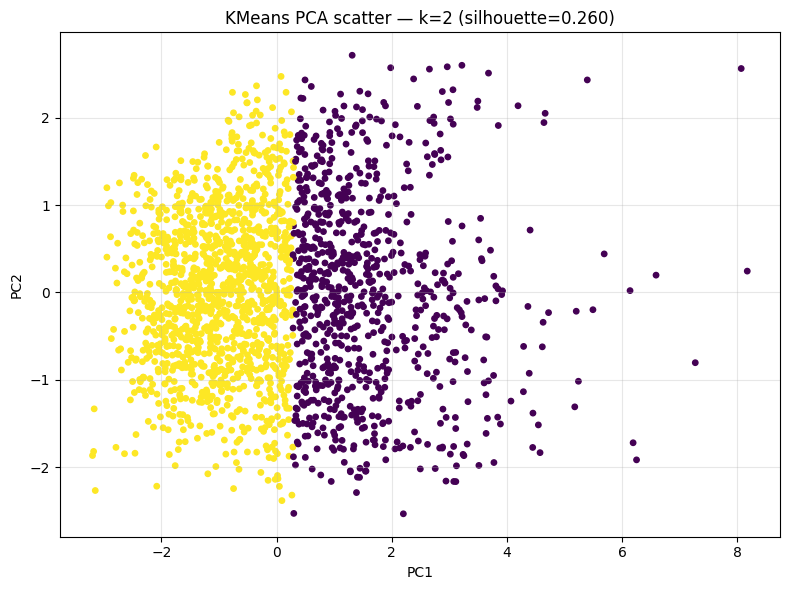

[OK] Figura guardada: ..\docs\plots\kmeans_pca_scatter.png


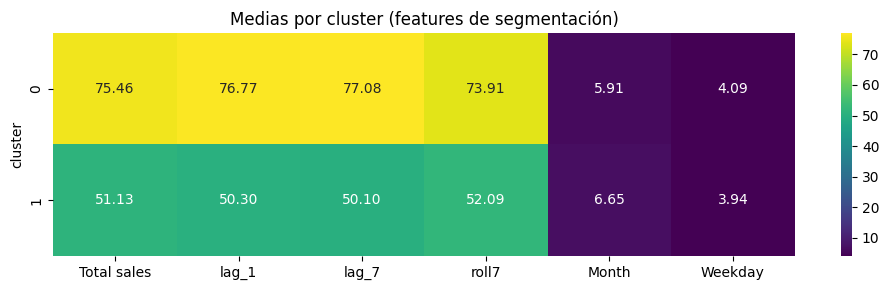

[OK] Figura guardada: ..\docs\plots\kmeans_features_heatmap.png


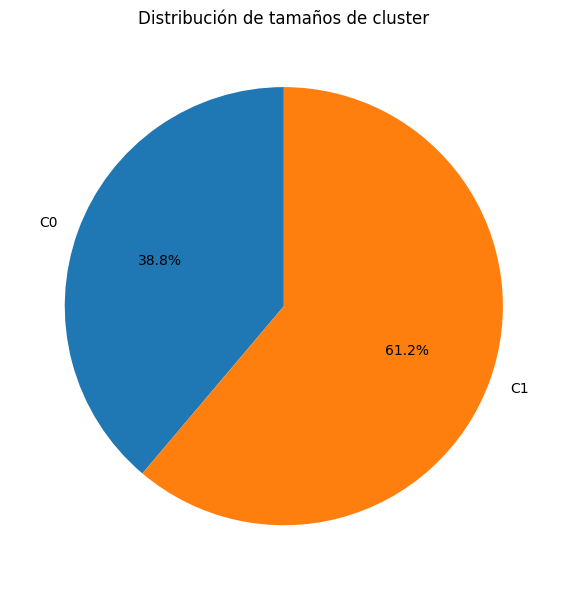

[OK] Figura guardada: ..\docs\plots\kmeans_cluster_sizes.png


In [13]:
# #########################################
# 7 - CLUSTERING (NO SUPERVISADO)
# #########################################

# === Clustering de días (KMeans) ===

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score

# 1) Prepara tus features de segmentación
d, _ = add_time_features_daily(df_salesdaily_training)
d = d.dropna(subset=["Total sales"]).copy()

cols_seg = [c for c in ["Total sales", "lag_1", "lag_7", "roll7", "Month", "Weekday"] if c in d.columns]
Z = d[cols_seg].astype(float)   # DataFrame para conservar nombres

# 2) Elegimos k por silhouette con un Pipeline (scaler + kmeans)
best_k, best_score, best_pipe = None, -1.0, None
for k in [2, 3, 4, 5]:
    pipe = Pipeline(steps=[
        ("scaler", StandardScaler()),
        ("kmeans", KMeans(n_clusters=k, n_init="auto", random_state=42))
    ])
    pipe.fit(Z)
    # Transformación para silhouette
    Zs = pipe.named_steps["scaler"].transform(Z)
    labels = pipe.named_steps["kmeans"].labels_
    s = silhouette_score(Zs, labels)
    if s > best_score:
        best_k, best_score, best_pipe = k, s, pipe

print(f"=== KMeans (Pipeline) ===\nMejor k={best_k} | silhouette={best_score:.3f}")

# 3) Etiquetas y resumen
labels = best_pipe.named_steps["kmeans"].labels_
d = d.copy()
d["cluster"] = labels

resumen = d.groupby("cluster").agg(
    dias=("cluster","count"),
    venta_media=("Total sales","mean"),
    venta_mediana=("Total sales","median"),
    venta_p95=("Total sales", lambda x: np.percentile(x,95))
).sort_values("venta_media", ascending=False)

print("\nResumen clusters (días):")
print(resumen.round(2).to_string())

# 4) Muestra 3 fechas ejemplo por cluster
ejemplos = d.groupby("cluster").head(3)[["datum","Total sales","cluster"]].sort_values(["cluster","datum"])
print("\nEjemplos de fechas por cluster:")
print(ejemplos.to_string(index=False))

# ===== Persistencia de resultados y gráficas del clustering =====
from pathlib import Path
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

DOCS_DIR = Path("../docs")
ARTI_DIR = DOCS_DIR / "artifacts"
PLOTS_DIR = DOCS_DIR / "plots"
ARTI_DIR.mkdir(parents=True, exist_ok=True)
PLOTS_DIR.mkdir(parents=True, exist_ok=True)

# 5) Guardar asignaciones por fecha
out_clusters_csv = ARTI_DIR / "daily_clusters.csv"
d_out = d[["datum", "Total sales", "cluster"] + [c for c in cols_seg if c in d.columns]].copy()
d_out.rename(columns={"datum": "fecha", "Total sales": "ventas"}, inplace=True)
d_out.to_csv(out_clusters_csv, index=False)
print(f"[OK] Guardado: {out_clusters_csv}")

# 6) Guardar resumen por cluster
out_summary_csv = ARTI_DIR / "cluster_summary.csv"
resumen.round(4).to_csv(out_summary_csv)
print(f"[OK] Guardado: {out_summary_csv}")

# === Métrica de clustering (silhouette + k) ===
cluster_metric_path = ARTI_DIR / "cluster_metric.csv"
pd.DataFrame([{"Silhouette": best_score, "k": best_k}], index=["KMeans"]).to_csv(cluster_metric_path)
print(f"[OK] Guardado: {cluster_metric_path}")

# 7) Scatter 2D (PCA) coloreado por cluster
pca = PCA(n_components=2, random_state=42)
Zs = best_pipe.named_steps["scaler"].transform(Z)  # ya escalado en el pipeline
XY = pca.fit_transform(Zs)
plt.figure(figsize=(8,6))
scatter = plt.scatter(XY[:,0], XY[:,1], c=labels, s=15)
plt.title(f"KMeans PCA scatter — k={best_k} (silhouette={best_score:.3f})")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.grid(alpha=0.3)
plt.tight_layout()
p_scatter = PLOTS_DIR / "kmeans_pca_scatter.png"
plt.savefig(p_scatter, dpi=150)
plt.show()
plt.close()
print(f"[OK] Figura guardada: {p_scatter}")

# 8) Heatmap de medias por cluster (sobre cols_seg)
heat_df = d.groupby("cluster")[cols_seg].mean().round(3)
plt.figure(figsize=(10, max(3, 0.5*len(cols_seg))))
sns.heatmap(heat_df, annot=True, fmt=".2f", cmap="viridis")
plt.title("Medias por cluster (features de segmentación)")
plt.tight_layout()
p_heat = PLOTS_DIR / "kmeans_features_heatmap.png"
plt.savefig(p_heat, dpi=150)
plt.show()
plt.close()
print(f"[OK] Figura guardada: {p_heat}")

# 9) Pie chart tamaños de cluster
sizes = d["cluster"].value_counts().sort_index()
plt.figure(figsize=(6,6))
plt.pie(sizes, labels=[f"C{c}" for c in sizes.index], autopct="%1.1f%%", startangle=90)
plt.title("Distribución de tamaños de cluster")
plt.tight_layout()
p_pie = PLOTS_DIR / "kmeans_cluster_sizes.png"
plt.savefig(p_pie, dpi=150)
plt.show()
plt.close()
print(f"[OK] Figura guardada: {p_pie}")

Me quedo con un subconjunto “segmentador”:
- Total sales → nivel del día (lo principal).
- lag_1, lag_7, roll7 → memoria de corto plazo y tendencia semanal.
- Month, Weekday → estacionalidad anual y patrón semanal.

`Z` es la matriz numérica sobre la que haremos clustering (cada fila = un día).

**¿Cómo leer el resultado?**
- Un clúster con venta_media alta y venta_p95 altísima → “días pico” (posibles promos, lanzamientos, estacionalidad).
- Uno con venta_media baja y mediana baja → “días valle” (pueden ser fines de semana, festivos, etc.).
- Si un clúster tiene pocos días (dias muy bajo), puede ser ruido o eventos especiales (útil para alertas).

**Conclusiones**  

Segmentación operativa
- Clúster “pico” ⇒ prever más stock y más personal.
- Clúster “valle” ⇒ optimizar costes, quizá impulsar promos.

Calendario y estacionalidad
- Si el clúster de ventas altas se concentra en ciertos meses o ciertos días de la semana, hay una estacionalidad clara.

Alertas
- Si aparecen nuevos días etiquetados como “pico”, puedes activar avisos tempranos.

Estrategia de marketing
- Alinear campañas con los clústeres propensos a responder mejor.

In [14]:
# === Helper: guardar importancias de variables de un Pipeline con .named_steps["model"] ===
from pathlib import Path
import matplotlib.pyplot as plt

def save_feature_importances(pipe, model_key: str, feat_names, arti_dir=ARTI_DIR, plots_dir=PLOTS_DIR):
    try:
        model = pipe.named_steps.get("model", None)
        if model is None:
            return
        if hasattr(model, "feature_importances_"):
            importancias = pd.Series(model.feature_importances_, index=feat_names).sort_values(ascending=False)
            out_csv = arti_dir / f"feature_importances_{model_key}.csv"
            importancias.to_csv(out_csv, header=["importance"])
            print(f"[OK] Guardado: {out_csv}")

            top = importancias.head(15).iloc[::-1]
            plt.figure(figsize=(8, max(3, 0.4*len(top))))
            plt.barh(top.index, top.values)
            plt.title(f"Feature importances — {model_key}")
            plt.tight_layout()
            out_png = plots_dir / f"feature_importances_{model_key}.png"
            plt.savefig(out_png, dpi=150)
            plt.close()
            print(f"[OK] Figura guardada: {out_png}")
    except Exception as e:
        print(f"[AVISO] No se pudieron guardar importancias de {model_key}: {e}")

### <u><span style="background-color: #00ffb792;">__B) Tabla comparativa__</span></u>  

In [15]:
# #########################################
# TABLA COMPARATIVA
# #########################################

# === Comparativa con pipelines (base + best si existen) ===

resultados = {}     # Creamos un diccionario para guardar resultados

# 1) Prophet <-- lo haré más tarde

# 2) SARIMAX (solo para tabla; NO se exporta como modelo entrenado)
if "res_sarimax" in globals():
    resultados["SARIMAX"] = res_sarimax

# 3) Random Forest (base + best)
if "rf_pipe" in globals():
    try: resultados["RandomForest (base)"] = evaluar(y_test, rf_pipe.predict(X_test))
    except Exception: pass
if "rf_best" in globals():
    try: resultados["RandomForest (best)"] = evaluar(y_test, rf_best.predict(X_test))
    except Exception: pass

# 4) Gradient Boosting Regressor (base + best)
if "gbr_pipe" in globals():
    try: resultados["GradientBoosting (base)"] = evaluar(y_test, gbr_pipe.predict(X_test))
    except Exception: pass
if "gbr_best" in globals():
    try: resultados["GradientBoosting (best)"] = evaluar(y_test, gbr_best.predict(X_test))
    except Exception: pass

# 5) XGBoost (base + best)
if "xgb_pipe" in globals():
    try: resultados["XGBoost (base)"] = evaluar(y_test, xgb_pipe.predict(X_test))
    except Exception: pass
if "xgb_best" in globals():
    try: resultados["XGBoost (best)"] = evaluar(y_test, xgb_best.predict(X_test))
    except Exception: pass

# 6) CatBoost (base + best)
if "cat_pipe" in globals():
    try: resultados["CatBoost (base)"] = evaluar(y_test, cat_pipe.predict(X_test))
    except Exception: pass
if "cat_best" in globals():
    try: resultados["CatBoost (best)"] = evaluar(y_test, cat_best.predict(X_test))
    except Exception: pass

# Ahora construimos df_resumen y mostramos la tabla comparativa (MAPE/MAE/MSE/R2)
df_resumen = pd.DataFrame(resultados).T
df_resumen = df_resumen[["MAPE","MAE","MSE","R2"]].sort_values("MAPE")

print("=== Comparativa de modelos ===")
print(df_resumen.round(3).to_string())

# 7) Clustering
if "best_k" in globals() and "best_score" in globals():
    df_clust = pd.DataFrame([{"Silhouette": best_score, "k": best_k}], index=["KMeans"])
    print("\n=== Métrica de clustering (no supervisado) ===")
    print(df_clust.round(3).to_string())
    print()

# === Persistir importancias de variables (si el modelo las expone) ===
try:
    save_feature_importances(rf_best,  "RF_best",  feat_cols)
except Exception as e:
    print("[AVISO] RF_best:", e)

try:
    save_feature_importances(gbr_best, "GBR_best", feat_cols)
except Exception as e:
    print("[AVISO] GBR_best:", e)

try:
    if 'xgb_best' in globals():
        save_feature_importances(xgb_best, "XGB_best", feat_cols)
except Exception as e:
    print("[AVISO] XGB_best:", e)

try:
    if 'cat_best' in globals():
        save_feature_importances(cat_best, "CAT_best", feat_cols)
except Exception as e:
    print("[AVISO] CAT_best:", e)

=== Comparativa de modelos ===
                           MAPE     MAE       MSE     R2
CatBoost (base)           1.345   1.018     9.324  0.982
CatBoost (best)           1.476   0.986     4.180  0.992
XGBoost (best)            1.964   1.235     3.716  0.993
GradientBoosting (best)   1.996   1.277     3.984  0.992
XGBoost (base)            2.374   1.531     7.634  0.986
GradientBoosting (base)   2.578   1.650     6.523  0.988
RandomForest (best)       5.093   3.284    26.306  0.950
RandomForest (base)       5.192   3.349    27.208  0.948
SARIMAX                  33.571  25.072  1018.464 -0.938

=== Métrica de clustering (no supervisado) ===
        Silhouette  k
KMeans        0.26  2

[OK] Guardado: ..\docs\artifacts\feature_importances_RF_best.csv
[OK] Figura guardada: ..\docs\plots\feature_importances_RF_best.png
[OK] Guardado: ..\docs\artifacts\feature_importances_GBR_best.csv
[OK] Figura guardada: ..\docs\plots\feature_importances_GBR_best.png
[OK] Guardado: ..\docs\artifacts\featu

**CatBoost (best)** es el modelo con mejor desempeño global:  
- Presenta los **errores más bajos** (MAPE y MAE ≈ 1.0–1.3%).  
- **MSE muy reducido** (≈ 4.2), en línea con los mejores modelos.  
- **R² ≈ 0.992**, lo que significa que explica más del 99% de la variabilidad en ventas.

**XGBoost (best)** y **Gradient Boosting (best)** se sitúan muy cerca:  
- XGB_best logra **MAPE ≈ 1.96%** y **R² ≈ 0.993**, prácticamente empatado con CatBoost.  
- GBR_best queda apenas detrás (**MAPE ≈ 1.99%, R² ≈ 0.992**).  
- Ambos representan alternativas sólidas y más estándar de cara a producción.

**Random Forest** y **SARIMAX** quedan bastante por detrás:  
- RF supera el **5% de error medio**.  
- SARIMAX obtiene un **R² negativo**, señal de que no captura la estacionalidad y predice peor que la media.

---

**Conclusión:** CatBoost ofrece el mejor rendimiento en este conjunto de datos, seguido muy de cerca por XGBoost y Gradient Boosting. Para despliegue, XGBoost o Gradient Boosting podrían ser opciones más prácticas si se prioriza estabilidad y soporte a largo plazo, mientras que CatBoost es la elección óptima si el objetivo es minimizar al máximo los errores.

---

El clustering no aparece porque:
- No es un modelo supervisado de predicción, sino de segmentación.
- No genera valores predichos y_pred para comparar con y_test.
- En vez de métricas como MAPE, MAE o R², se evalúa con métricas de cohesión/separación (ej: silhouette score, Davies–Bouldin, Calinski–Harabasz).

### <u><span style="background-color: #00ffb792;">__C) Gráficas__</span></u>


Mejor modelo: CatBoost (base)


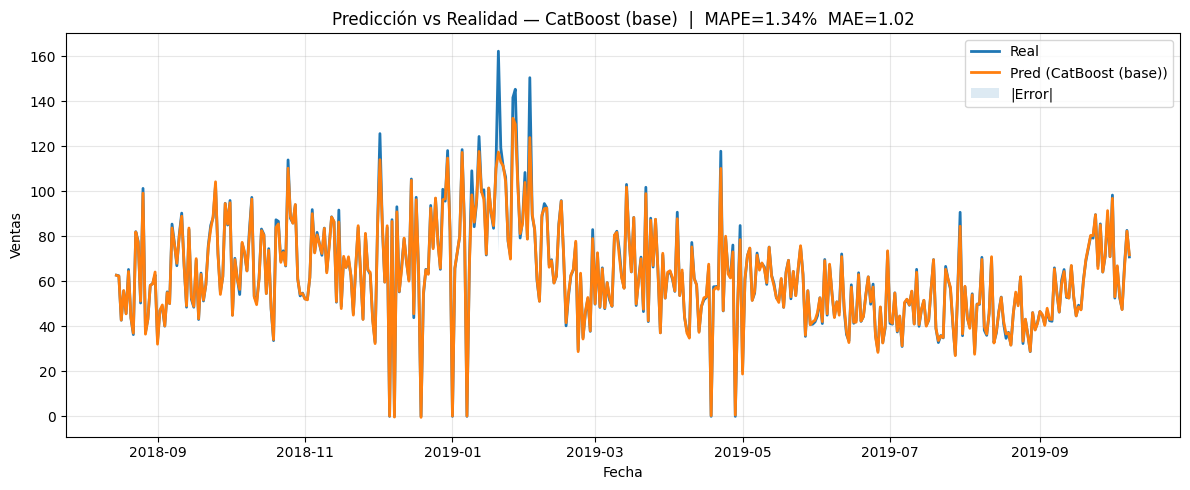

[OK] Guardado: ..\docs\artifacts\eval_metrics.csv
[OK] Guardado: ..\docs\artifacts\eval_metrics.md
[OK] Guardado: ..\docs\artifacts\y_true_pred.csv
[OK] Guardado: ..\docs\artifacts\eval_metrics.csv
[OK] Guardado: ..\docs\artifacts\eval_metrics.md
[OK] Guardado: ..\docs\artifacts\y_true_pred.csv


In [16]:
# #########################################
# GRÁFICAS
# #########################################

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- 1) Elegimos el mejor por MAPE ---
mejor_modelo = df_resumen.sort_values("MAPE").index[0]
print(f"\nMejor modelo: {mejor_modelo}")

# --- 2) Función auxiliar para obtener predicciones y fechas ---
def _pred_y_fechas(nombre_modelo):
    """
    Devuelve (y_true, y_pred, fechas_test) alineados para graficar.
    Soporta SARIMAX y modelos tipo RandomForest / GradientBoosting / XGBoost / CatBoost,
    con o sin sufijos '(base)'/'(best)' en el nombre.
    """
    nombre = nombre_modelo.lower()

    # SARIMAX (usa yhat y el tramo temporal del test)
    if "sarimax" in nombre:
        y_true = np.asarray(y_te, dtype=float)
        y_pred = np.asarray(yhat, dtype=float)
        fechas_test = pd.to_datetime(daily["datum"].iloc[cut:]).values
        return y_true, y_pred, fechas_test

    # Modelos sklearn/catboost/xgboost en pipelines
    # Prioridad: 'best' si existe
    model = None
    if ("gradientboosting" in nombre) and ("best" in nombre) and ("gbr_best" in globals()):
        model = gbr_best
    elif ("gradientboosting" in nombre) and ("gbr_pipe" in globals()):
        model = gbr_pipe

    elif ("randomforest" in nombre) and ("best" in nombre) and ("rf_best" in globals()):
        model = rf_best
    elif ("randomforest" in nombre) and ("rf_pipe" in globals()):
        model = rf_pipe

    elif ("xgboost" in nombre) and ("best" in nombre) and ("xgb_best" in globals()):
        model = xgb_best
    elif ("xgboost" in nombre) and ("xgb_pipe" in globals()):
        model = xgb_pipe

    elif ("catboost" in nombre) and ("best" in nombre) and ("cat_best" in globals()):
        model = cat_best
    elif ("catboost" in nombre) and ("cat_pipe" in globals()):
        model = cat_pipe

    else:
        # Fallback a objetos sin pipeline si los hubieras creado con otros nombres
        if ("randomforest" in nombre) and ("rf" in globals()):
            model = rf
        elif ("gradientboosting" in nombre) and ("gbr" in globals()):
            model = gbr
        elif ("xgboost" in nombre) and ("xgb" in globals()):
            model = xgb
        elif ("catboost" in nombre) and ("cat" in globals()):
            model = cat

    if model is None:
        raise RuntimeError(f"No encuentro el estimador para '{nombre_modelo}'. Revisa variables en memoria.")

    # Predicciones con el tramo test del diseño supervisado
    y_true = np.asarray(y_test, dtype=float)
    y_pred = np.asarray(model.predict(X_test), dtype=float)

    # Fechas del tramo test (si guardaste 'fechas', úsalo)
    if "fechas" in globals():
        fechas_test = pd.to_datetime(fechas[-len(y_true):]).values
    else:
        fechas_test = np.arange(len(y_true))  # fallback numérico

    return y_true, y_pred, fechas_test

# --- 3) Obtenemos y alineamos ---
y_true, y_pred, fechas_test = _pred_y_fechas(mejor_modelo)

# Alinear longitudes por seguridad
n = min(len(y_true), len(y_pred), len(fechas_test))
y_true = y_true[-n:]
y_pred = y_pred[-n:]
fechas_plot = fechas_test[-n:]

# Métricas para el título
res_mejor = evaluar(y_true, y_pred)
mape_val = res_mejor["MAPE"]
mae_val  = res_mejor["MAE"]

# --- 4) Gráfico con banda de error ---
plt.figure(figsize=(12, 5))
plt.plot(fechas_plot, y_true, label="Real", lw=2)
plt.plot(fechas_plot, y_pred, label=f"Pred ({mejor_modelo})", lw=2)

# banda de error (|y_true - y_pred|)
abs_err = np.abs(y_true - y_pred)
plt.fill_between(fechas_plot, y_pred - abs_err, y_pred + abs_err, alpha=0.15, label="|Error|")

plt.title(f"Predicción vs Realidad — {mejor_modelo}  |  MAPE={mape_val:.2f}%  MAE={mae_val:.2f}")
plt.xlabel("Fecha"); plt.ylabel("Ventas")
plt.grid(True, alpha=0.3); plt.legend()
plt.tight_layout()

from pathlib import Path
PLOTS_DIR = Path("../docs/plots"); PLOTS_DIR.mkdir(parents=True, exist_ok=True)
plt.savefig(PLOTS_DIR / "forecast_best_model_matplotlib.png", dpi=150)  # guardar antes de imprimir por pantalla la imagen
plt.show()

# === Exportar métricas y y_true/y_pred del modelo final (como evaluation.py) ===
# 1) Localiza el estimador real a partir del nombre 'mejor_modelo' de df_resumen
nombre = mejor_modelo.lower()
modelo_final = None

if "sarimax" in nombre and 'yhat' in globals():
    # SARIMAX no es sklearn; para coherencia de exportes usaremos los del tramo test ya calculado (y_te vs yhat)
    y_true_eval = np.asarray(y_te, dtype=float)
    y_pred_eval = np.asarray(yhat, dtype=float)
    fechas_eval = pd.to_datetime(daily["datum"].iloc[cut:]).to_numpy()
else:
    # Mapear a los pipelines entrenados
    if ("gradientboosting" in nombre) and ("best" in nombre) and ("gbr_best" in globals()):
        modelo_final = gbr_best
    elif ("gradientboosting" in nombre) and ("gbr_pipe" in globals()):
        modelo_final = gbr_pipe
    elif ("randomforest" in nombre) and ("best" in nombre) and ("rf_best" in globals()):
        modelo_final = rf_best
    elif ("randomforest" in nombre) and ("rf_pipe" in globals()):
        modelo_final = rf_pipe
    elif ("xgboost" in nombre) and ("best" in nombre) and ("xgb_best" in globals()):
        modelo_final = xgb_best
    elif ("xgboost" in nombre) and ("xgb_pipe" in globals()):
        modelo_final = xgb_pipe
    elif ("catboost" in nombre) and ("best" in nombre) and ("cat_best" in globals()):
        modelo_final = cat_best
    elif ("catboost" in nombre) and ("cat_pipe" in globals()):
        modelo_final = cat_pipe

    if modelo_final is None:
        raise RuntimeError(f"No encuentro el estimador para '{mejor_modelo}'. Revisa variables en memoria.")

    y_true_eval = np.asarray(y_test, dtype=float)
    y_pred_eval = np.asarray(modelo_final.predict(X_test), dtype=float)
    # Fechas del test
    if "fechas" in globals():
        fechas_eval = pd.to_datetime(fechas[-len(y_true_eval):]).to_numpy()
    else:
        fechas_eval = np.arange(len(y_true_eval))

# 2) Métricas y exportes
from pathlib import Path
def _save_md_table(df, path: Path):
    try:
        md = df.to_markdown(index=True)
    except Exception:
        md = "```\n" + df.to_string() + "\n```"
    with open(path, "w", encoding="utf-8") as f:
        f.write(md)

# eval_metrics.csv / .md
metrics = evaluar(y_true_eval, y_pred_eval)
metrics_df = pd.DataFrame([metrics], index=["final_model"])
eval_csv = ARTI_DIR / "eval_metrics.csv"
metrics_df.round(4).to_csv(eval_csv, index=True)
print(f"[OK] Guardado: {eval_csv}")

eval_md = ARTI_DIR / "eval_metrics.md"
_save_md_table(metrics_df.round(4), eval_md)
print(f"[OK] Guardado: {eval_md}")

# y_true_pred.csv
yp_csv = ARTI_DIR / "y_true_pred.csv"
pd.DataFrame({
    "fecha": pd.to_datetime(fechas_eval),
    "y_true": y_true_eval,
    "y_pred": y_pred_eval
}).to_csv(yp_csv, index=False)
print(f"[OK] Guardado: {yp_csv}")

# === Exportar métricas y y_true/y_pred del modelo final (como evaluation.py) ===
# 1) Localiza el estimador real a partir del nombre 'mejor_modelo' de df_resumen
nombre = mejor_modelo.lower()
modelo_final = None

if "sarimax" in nombre and 'yhat' in globals():
    # SARIMAX no es sklearn; para coherencia de exportes usaremos los del tramo test ya calculado (y_te vs yhat)
    y_true_eval = np.asarray(y_te, dtype=float)
    y_pred_eval = np.asarray(yhat, dtype=float)
    fechas_eval = pd.to_datetime(daily["datum"].iloc[cut:]).to_numpy()
else:
    # Mapear a los pipelines entrenados
    if ("gradientboosting" in nombre) and ("best" in nombre) and ("gbr_best" in globals()):
        modelo_final = gbr_best
    elif ("gradientboosting" in nombre) and ("gbr_pipe" in globals()):
        modelo_final = gbr_pipe
    elif ("randomforest" in nombre) and ("best" in nombre) and ("rf_best" in globals()):
        modelo_final = rf_best
    elif ("randomforest" in nombre) and ("rf_pipe" in globals()):
        modelo_final = rf_pipe
    elif ("xgboost" in nombre) and ("best" in nombre) and ("xgb_best" in globals()):
        modelo_final = xgb_best
    elif ("xgboost" in nombre) and ("xgb_pipe" in globals()):
        modelo_final = xgb_pipe
    elif ("catboost" in nombre) and ("best" in nombre) and ("cat_best" in globals()):
        modelo_final = cat_best
    elif ("catboost" in nombre) and ("cat_pipe" in globals()):
        modelo_final = cat_pipe

    if modelo_final is None:
        raise RuntimeError(f"No encuentro el estimador para '{mejor_modelo}'. Revisa variables en memoria.")

    y_true_eval = np.asarray(y_test, dtype=float)
    y_pred_eval = np.asarray(modelo_final.predict(X_test), dtype=float)
    # Fechas del test
    if "fechas" in globals():
        fechas_eval = pd.to_datetime(fechas[-len(y_true_eval):]).to_numpy()
    else:
        fechas_eval = np.arange(len(y_true_eval))

# 2) Métricas y exportes
from pathlib import Path
def _save_md_table(df, path: Path):
    try:
        md = df.to_markdown(index=True)
    except Exception:
        md = "```\n" + df.to_string() + "\n```"
    with open(path, "w", encoding="utf-8") as f:
        f.write(md)

# eval_metrics.csv / .md
metrics = evaluar(y_true_eval, y_pred_eval)
metrics_df = pd.DataFrame([metrics], index=["final_model"])
eval_csv = ARTI_DIR / "eval_metrics.csv"
metrics_df.round(4).to_csv(eval_csv, index=True)
print(f"[OK] Guardado: {eval_csv}")

eval_md = ARTI_DIR / "eval_metrics.md"
_save_md_table(metrics_df.round(4), eval_md)
print(f"[OK] Guardado: {eval_md}")

# y_true_pred.csv
yp_csv = ARTI_DIR / "y_true_pred.csv"
pd.DataFrame({
    "fecha": pd.to_datetime(fechas_eval),
    "y_true": y_true_eval,
    "y_pred": y_pred_eval
}).to_csv(yp_csv, index=False)
print(f"[OK] Guardado: {yp_csv}")

Con plotly:

In [17]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go

# --- 1) Elegimos el mejor por MAPE ---
mejor_modelo = df_resumen.sort_values("MAPE").index[0]
print(f"Mejor modelo: {mejor_modelo}")

# --- 2) Auxiliar: obtener y_true, y_pred y fechas (VERSIÓN COMPLETA) ---
def _pred_y_fechas(nombre_modelo):
    """
    Devuelve (y_true, y_pred, fechas_test) alineados para graficar.
    Soporta SARIMAX y modelos tipo RandomForest / GradientBoosting / XGBoost / CatBoost,
    con o sin sufijos '(base)'/'(best)' en el nombre.
    """
    nombre = nombre_modelo.lower()

    # SARIMAX: usa yhat y fechas del tramo test del daily
    if "sarimax" in nombre:
        y_true = np.asarray(y_te, dtype=float)
        y_pred = np.asarray(yhat, dtype=float)
        fechas_test = pd.to_datetime(daily["datum"].iloc[cut:]).to_numpy()
        return y_true, y_pred, fechas_test

    # Modelos sklearn/cat/xgb (prioridad a 'best' si existe)
    model = None

    # GradientBoosting
    if ("gradientboosting" in nombre) and ("best" in nombre) and ("gbr_best" in globals()):
        model = gbr_best
    elif ("gradientboosting" in nombre) and ("gbr_pipe" in globals()):
        model = gbr_pipe

    # RandomForest
    elif ("randomforest" in nombre) and ("best" in nombre) and ("rf_best" in globals()):
        model = rf_best
    elif ("randomforest" in nombre) and ("rf_pipe" in globals()):
        model = rf_pipe

    # XGBoost
    elif ("xgboost" in nombre) and ("best" in nombre) and ("xgb_best" in globals()):
        model = xgb_best
    elif ("xgboost" in nombre) and ("xgb_pipe" in globals()):
        model = xgb_pipe

    # CatBoost  ⬅️ (falta en tu versión anterior)
    elif ("catboost" in nombre) and ("best" in nombre) and ("cat_best" in globals()):
        model = cat_best
    elif ("catboost" in nombre) and ("cat_pipe" in globals()):
        model = cat_pipe

    else:
        # Fallback a objetos sin pipeline si existieran
        if ("randomforest" in nombre) and ("rf" in globals()):
            model = rf
        elif ("gradientboosting" in nombre) and ("gbr" in globals()):
            model = gbr
        elif ("xgboost" in nombre) and ("xgb" in globals()):
            model = xgb
        elif ("catboost" in nombre) and ("cat" in globals()):
            model = cat

    if model is None:
        raise RuntimeError(f"No encuentro el estimador para '{nombre_modelo}'. Revisa variables en memoria.")

    # Predicciones con el tramo test del diseño supervisado
    y_true = np.asarray(y_test, dtype=float)
    y_pred = np.asarray(model.predict(X_test), dtype=float)

    # Fechas del test (si guardaste 'fechas', úsalo)
    if "fechas" in globals():
        fechas_test = pd.to_datetime(fechas[-len(y_true):]).to_numpy()
    else:
        fechas_test = np.arange(len(y_true))  # fallback numérico

    return y_true, y_pred, fechas_test

# --- 3) Obtenemos datos y alineamos ---
y_true, y_pred, fechas_plot = _pred_y_fechas(mejor_modelo)
n = min(len(y_true), len(y_pred), len(fechas_plot))
y_true, y_pred, fechas_plot = y_true[-n:], y_pred[-n:], fechas_plot[-n:]

# Métricas
res = evaluar(y_true, y_pred)
mape_val, mae_val = res["MAPE"], res["MAE"]
abs_err = np.abs(y_true - y_pred)

# --- 4) Figura Plotly ---
fig = go.Figure()

# Real
fig.add_trace(go.Scatter(
    x=fechas_plot, y=y_true,
    mode="lines",
    name="Real",
    hovertemplate="Fecha: %{x}<br>Real: %{y:.2f}<extra></extra>"
))

# Predicción
fig.add_trace(go.Scatter(
    x=fechas_plot, y=y_pred,
    mode="lines",
    name=f"Pred ({mejor_modelo})",
    hovertemplate="Fecha: %{x}<br>Pred: %{y:.2f}<extra></extra>"
))

# Banda de error (±|y - yhat|)
fig.add_trace(go.Scatter(
    x=np.concatenate([fechas_plot, fechas_plot[::-1]]),
    y=np.concatenate([y_pred + abs_err, (y_pred - abs_err)[::-1]]),
    fill="toself",
    name="|Error|",
    opacity=0.2,
    line=dict(width=0),
    hoverinfo="skip"
))

fig.update_layout(
    title=f"Predicción vs Realidad — {mejor_modelo} | MAPE={mape_val:.2f}%  MAE={mae_val:.2f}",
    xaxis_title="Fecha",
    yaxis_title="Ventas",
    hovermode="x unified",
    margin=dict(l=40, r=20, t=70, b=40),
)

# Controles extra
fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(
    updatemenus=[dict(
        type="buttons",
        x=1.02, y=1.15,
        buttons=[
            dict(label="Reset zoom", method="relayout", args=[{"xaxis.autorange": True, "yaxis.autorange": True}]),
        ]
    )]
)

fig.show()

from pathlib import Path
import plotly.io as pio
PLOTS_DIR = Path("../docs/plots"); PLOTS_DIR.mkdir(parents=True, exist_ok=True)
pio.write_json(fig, PLOTS_DIR / "forecast_best_model_plotly.json")
fig.write_html(str(PLOTS_DIR / "forecast_best_model_plotly.html"), include_plotlyjs="cdn")
print("[OK] Guardado Plotly JSON/HTML en docs/plots/")

Mejor modelo: CatBoost (base)


[OK] Guardado Plotly JSON/HTML en docs/plots/


**¿Cómo interpretar la gráfica?**

- **Línea azul (“Real”)** → representa las **ventas reales observadas** en el conjunto de test.  
- **Línea naranja (“Pred”)** → muestra las **predicciones del mejor modelo según MAPE**.  
- **Banda semitransparente** → indica el **error absoluto** (`±|y_true - y_pred|`) alrededor de la predicción.  
  - **Banda estrecha** → el modelo predice con poca desviación (alto acierto).  
  - **Banda ancha** → el modelo comete más error en esas fechas.


**¿Qué debemos mirar?**

1. **Ajuste general** → comprobar si la línea de predicción sigue bien la forma de la serie real (picos y valles).  
2. **Captura de picos y valles** → si el modelo **suaviza demasiado** los picos, puede estar perdiendo información de variabilidad.  
3. **Sesgo sistemático** → si la predicción está **siempre por encima o por debajo**, el modelo tiene un sesgo.  
4. **Métricas en el título**  
   - **MAPE (%)** → error porcentual medio, fácil de interpretar en términos de precisión relativa.  
   - **MAE** → error absoluto medio en **unidades de ventas** (útil para contexto de negocio).  

En resumen: lo ideal es que la línea naranja se superponga a la azul con una banda de error lo más estrecha posible.


### <u><span style="background-color: #00ffb792;">__D) Guardar modelos__</span></u>  

In [18]:
# #########################################
# GUARDAR MODELOS
# #########################################

import pickle
from pathlib import Path
import joblib

# Carpeta de salida
MODELS_DIR = Path("../models")
MODELS_DIR.mkdir(parents=True, exist_ok=True)

MODEL_ORDER = {
    "Prophet": 1,
    "ARIMA": 2,
    "RandomForest": 3,
    "GradientBoosting": 4,
    "XGBoost": 5,
    "CatBoost": 6,
    "Clustering": 7,
}

def _save_model_nb(model, label: str):
    fam_num = None
    for fam, num in MODEL_ORDER.items():
        if fam.lower() in label.lower():
            fam_num = num
            break
    if fam_num is None:
        fam_num = 99
    out_path = MODELS_DIR / f"trained_model_{fam_num}_{label}.pkl"
    joblib.dump(model, out_path)
    print(f"[OK] Guardado modelo: {out_path}")

# Recopilar modelos a guardar (NO guardamos Prophet/ARIMA/SARIMAX)
modelos_a_guardar = {}

# RandomForest
if "rf_pipe" in globals(): modelos_a_guardar["RandomForest_base"] = rf_pipe
if "rf_best" in globals(): modelos_a_guardar["RandomForest_best"] = rf_best

# GradientBoosting
if "gbr_pipe" in globals(): modelos_a_guardar["GradientBoosting_base"] = gbr_pipe
if "gbr_best" in globals(): modelos_a_guardar["GradientBoosting_best"] = gbr_best

# XGBoost
if "xgb_pipe" in globals(): modelos_a_guardar["XGBoost_base"] = xgb_pipe
if "xgb_best" in globals(): modelos_a_guardar["XGBoost_best"] = xgb_best

# CatBoost
if "cat_pipe" in globals(): modelos_a_guardar["CatBoost_base"] = cat_pipe
if "cat_best" in globals(): modelos_a_guardar["CatBoost_best"] = cat_best

# Clustering (KMeans) — aquí el añadido
if "best_pipe" in globals() and "best_k" in globals():
    modelos_a_guardar[f"Clustering_KMeans_k{int(best_k)}"] = best_pipe

# Guardado numerado
for label, model in modelos_a_guardar.items():
    _save_model_nb(model, label)

# (Opcional) final_model según df_resumen (sin Clustering/SARIMAX enumerados)
top_name = df_resumen.index[0]
name_map = {
    "RandomForest (best)": ("RandomForest_best", "rf_best"),
    "RandomForest (base)": ("RandomForest_base", "rf_pipe"),
    "GradientBoosting (best)": ("GradientBoosting_best", "gbr_best"),
    "GradientBoosting (base)": ("GradientBoosting_base", "gbr_pipe"),
    "XGBoost (best)": ("XGBoost_best", "xgb_best"),
    "XGBoost (base)": ("XGBoost_base", "xgb_pipe"),
    "CatBoost (best)": ("CatBoost_best", "cat_best"),
    "CatBoost (base)": ("CatBoost_base", "cat_pipe"),
}
if top_name in name_map and (name_map[top_name][1] in globals()):
    final_model = globals()[name_map[top_name][1]]
elif top_name.lower() == "sarimax" and "sarimax" in globals():
    final_model = sarimax
else:
    final_model = globals().get("rf_best", globals().get("gbr_best", None))

if final_model is not None:
    import pickle
    with open(MODELS_DIR / "final_model.pkl", "wb") as f:
        pickle.dump(final_model, f)
    print("[OK] final_model.pkl guardado en ../models")
else:
    print("[AVISO] No se pudo determinar un modelo final para guardar.")

[OK] Guardado modelo: ..\models\trained_model_3_RandomForest_base.pkl
[OK] Guardado modelo: ..\models\trained_model_3_RandomForest_best.pkl
[OK] Guardado modelo: ..\models\trained_model_4_GradientBoosting_base.pkl
[OK] Guardado modelo: ..\models\trained_model_4_GradientBoosting_best.pkl
[OK] Guardado modelo: ..\models\trained_model_5_XGBoost_base.pkl
[OK] Guardado modelo: ..\models\trained_model_5_XGBoost_best.pkl
[OK] Guardado modelo: ..\models\trained_model_6_CatBoost_base.pkl
[OK] Guardado modelo: ..\models\trained_model_6_CatBoost_best.pkl
[OK] Guardado modelo: ..\models\trained_model_7_Clustering_KMeans_k2.pkl
[OK] final_model.pkl guardado en ../models


In [19]:
# =========================================
# Exportar matriz comparativa
# =========================================

import os

ARTI_DIR = "../docs/artifacts"
os.makedirs(ARTI_DIR, exist_ok=True)

out_csv = os.path.join(ARTI_DIR, "metrics_summary.csv")
df_resumen.round(3).to_csv(out_csv, index=True)

print(f"Guardado: {out_csv}")

Guardado: ../docs/artifacts\metrics_summary.csv


In [20]:
# =========================================
# Exportar resultados a Markdown
# =========================================

import os

# Directorio donde guardar
DOCS_DIR = "../docs"
ARTI_DIR = os.path.join(DOCS_DIR, "artifacts")
os.makedirs(ARTI_DIR, exist_ok=True)

# Redondeamos y exportamos
df_resumen_round = df_resumen.round(3)

# Guardar en Markdown
md_path = os.path.join(ARTI_DIR, "metrics_summary.md")
try:
    md_text = df_resumen_round.to_markdown(index=True)
except Exception:
    # Fallback: tabla simple
    md_text = "```\n" + df_resumen_round.to_string() + "\n```"

with open(md_path, "w", encoding="utf-8") as f:
    f.write(md_text)

print(f"Exportado resumen de métricas a Markdown en: {md_path}")

Exportado resumen de métricas a Markdown en: ../docs\artifacts\metrics_summary.md
